In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from secsy import get_SECS_B_G_matrices, get_SECS_J_G_matrices, CSgrid, CSprojection
from EZIE.utils.simulation_utils import get_MHD_jeq, get_MHD_dB
from EZIE.utils.synthetic_satellite import get_satellite_state, get_observation_points
from orbit_predictor.sources import EtcTLESource # needed for tle -> orbit info
d2r = np.pi / 180

# Noise analysis

The purpose of this notebook is to explore how different noise levels affect the inversion, by running a series of simpliefied OSSEs. I will skip the step that simulates atmospheric emissions and instrument noise, and instead sample data directly from an MHD simulatio and add Gaussian noise with different sigmas. I will run the inversion based on measurements of only the radial component, avoiding the complication of off-diagonal elements in the covariance matrix.

## Step 1: Set up parameters for the simulation
I'll need a list of satellite positions and velocity vectors. For this I will use a TLE file that describes a Swarm orbit. We can rotate the MHD simulation to test different local times. 

I'll also need parameters such as a emission altitude, current altitude, etc. 





In [2]:
# MEASUREMENT PARAMETERS:
H_b = 85 # emission height - must match one of the MHD output files
cadence = 2 # measurement cadence in seconds, int
view_angles = [45, -5, -25, -45] # the angle of the antennas relative to nadir and perpendicular to flight direction
tlefn = './tle/swarmc.tle' # name of TLE file that specifies orbit
DT = 4 * 60 # time interval to consider, in seconds

# GRID PARAMETERS:
RI = (6371.2 + 110) * 1e3 # radius of ionosphere in meters
LRES, WRES = 20.e3, 40.e3 # resolution in m along track and across track, respectively
EXPAND = 1.3 # factor by which to expand the grid in cross-track direction


# get a time interval - the start and end are arbitrary, but should be adjusted so that the satellite is 
# at an interesting latitude
t0 = dt.datetime(2020, 1, 1, 0, 8)
t = pd.date_range(t0, t0 + dt.timedelta(seconds = DT), freq = str(cadence)+'S')

# produce MHD simulation filename based on H_b:
mhd_dB_fn = '../data/proposal_stage_mhd_data/gamera_dBs_Jfull_' + str(H_b) + 'km_2430'


## Step 2: Extract data from MHD simulation


In [3]:
# get satellite position and velocity vector:
r, theta, phi, v = get_satellite_state(t, tlefile = tlefn)

# get the observation points:
lon_obs, lat_obs = get_observation_points(r, theta, phi, v, alphas = view_angles, h = H_b)

# get MHD simulation values:
Br_mhd = get_MHD_dB(lat_obs, lon_obs, component = 'Br [nT]', fn = mhd_dB_fn)


# DERIVE EXTENT AND ORIENTATION OF GRID:
lon0, lat0 = phi[len(phi)//2], 90 - theta[len(theta)//2] # positions

v0 = v[len(v)//2][:2] # east, north components of mid measurement velocity
v0[0] = v0[0] - np.cos(lat0 * d2r) * RI *1e-3 * 2 * np.pi / (24 * 60**2) # adjust for Earth rotation
orientation = v0 / np.linalg.norm(v0) # normalize


# make Cartesian unit vectors of satellite track:
r_track = np.vstack((np.sin(theta * d2r) * np.cos(phi * d2r), 
                     np.sin(theta * d2r) * np.sin(phi * d2r), 
                     np.cos(theta * d2r)))
L = RI * np.arccos(np.sum(r_track[:, 0] * r_track[:, -1])) # along-track size of grid [m]

# do the same for left and right tracks and find the maximum distance between the tracks:
r_left  =  np.vstack((np.cos(lat_obs[ 0] * d2r) * np.cos(lon_obs[ 0] * d2r), 
                      np.cos(lat_obs[ 0] * d2r) * np.sin(lon_obs[ 0] * d2r), 
                      np.sin(lat_obs[ 0] * d2r)))
r_right =  np.vstack((np.cos(lat_obs[-1] * d2r) * np.cos(lon_obs[-1] * d2r), 
                      np.cos(lat_obs[-1] * d2r) * np.sin(lon_obs[-1] * d2r), 
                      np.sin(lat_obs[-1] * d2r)))
Ws = RI * np.arccos(np.sum(r_left * r_right, axis = 0))
W = np.max(Ws) * EXPAND # cross-track size of grid [m]

## Step 3: Set up the grid and plot measurements without noise

(-0.1444849216507034, 0.14404097854792544)

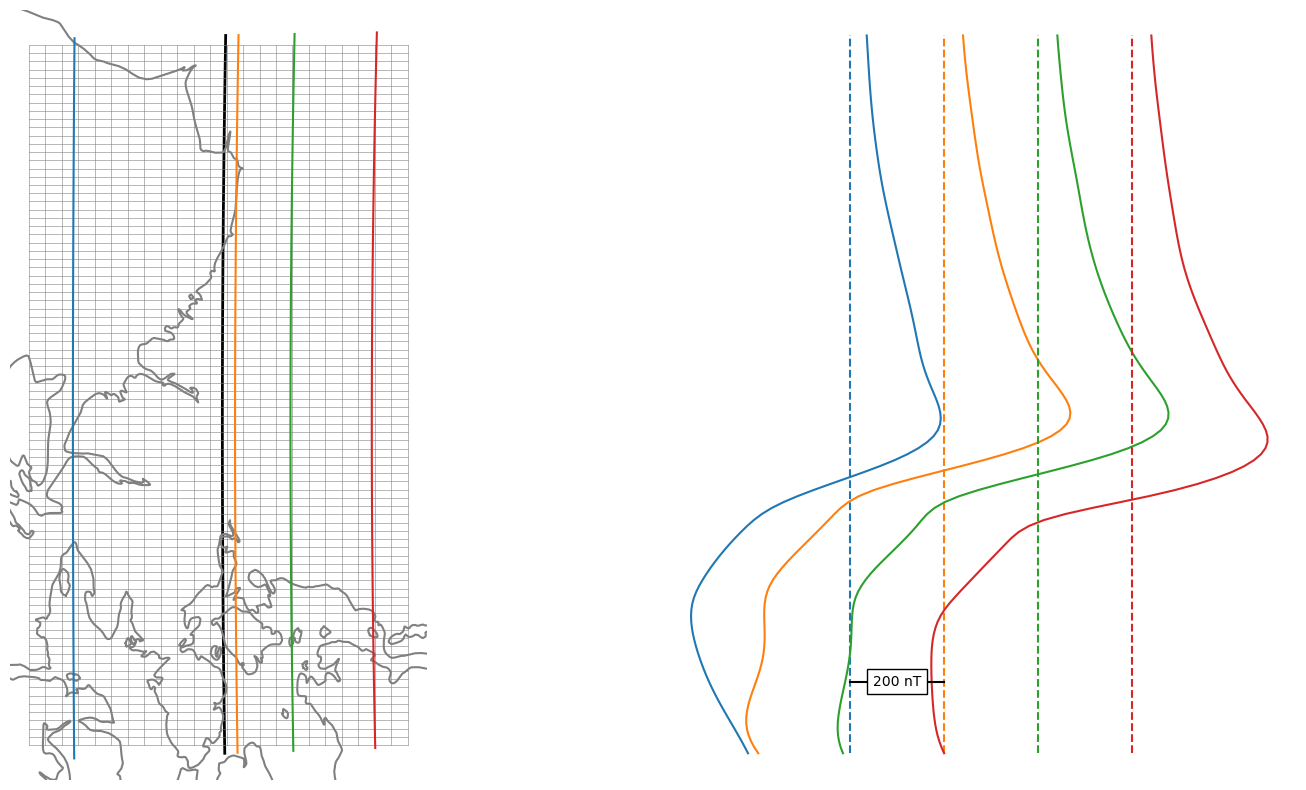

In [4]:
DB = 200 # number of nT offset between each plot

projection = CSprojection((lon0, lat0), orientation)
grid = CSgrid(projection, L, W, LRES, WRES, R = RI)

# Plot grid and coastlines:
fig, axes = plt.subplots(figsize = (18, 10), ncols = 2, sharey = True)

# PLOT THE GRID
ax = axes[0]
ax.set_axis_off()
ax.set_aspect('equal')
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color = 'grey', linewidth = .4)

# plot coastlines
xlim, ylim = ax.get_xlim(), ax.get_ylim()
for cl in grid.projection.get_projected_coastlines():
    ax.plot(cl[0], cl[1], color = 'grey')
    
# plot satellite track:
_xi, _eta = projection.geo2cube(phi, 90 - theta)
ax.plot(_xi, _eta, 'k-', linewidth = 2, zorder = 1)

# plot measurement tracks:
for i in range(4):
    _xi, _eta = projection.geo2cube(lon_obs[i], lat_obs[i])
    ax.plot(_xi, _eta, color = 'C' + str(i), zorder = 3)
    
# PLOT THE DATA
axB = axes[1]
axB.set_axis_off()

# get y axis:
_xi, y = projection.geo2cube(phi, 90 - theta)

for i in range(4):
    axB.plot(Br_mhd[i] * 0 + i * DB, y, linestyle = '--', color = 'C' + str(i))
    axB.plot(Br_mhd[i]     + i * DB, y, linestyle = '-', color = 'C' + str(i))

# plot a scale:
axB.plot([0, DB], [y[len(y)//10]]*2, color = 'black')
_ = axB.text(DB//2, y[len(y)//10], str(DB) + ' nT', ha = 'center', va = 'center', )
_.set_bbox(dict(facecolor='white', alpha=1, edgecolor=None)) 
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)

## Step 4: Calculate model matrices and run inversion

This step involves regularization, and we should discuss how to determine the regularization parameters. 

In [14]:
# get SECS B matrices:
Ge, Gn, Gu = get_SECS_B_G_matrices(lat_obs.flatten(), lon_obs.flatten(), (6371.2 + H_b) * 1e3, grid.lat.flatten(), grid.lon.flatten(), RI = RI )

GTG = Gu.T.dot(Gu) # we only use the radial component
scale = np.max(GTG) # used to adjust regularization paramters - THIS SHOULD BE FIXED!

Le, Ln = grid.get_Le_Ln() # differentiation matrices

# regularization matrix:
R = scale * (1e12 * Le.T.dot(Le) + 1e-2 * np.eye(GTG.shape[0])) # THIS SHOULD BE FIXED!

# calculate pseudo-inverse:
SS = np.linalg.inv(GTG + R)

# solution vector based on the no-noise data:
m = np.ravel(SS.dot(Gu.T.dot(Br_mhd.flatten())))



## Step 5: Compare inversion maps to MHD output maps

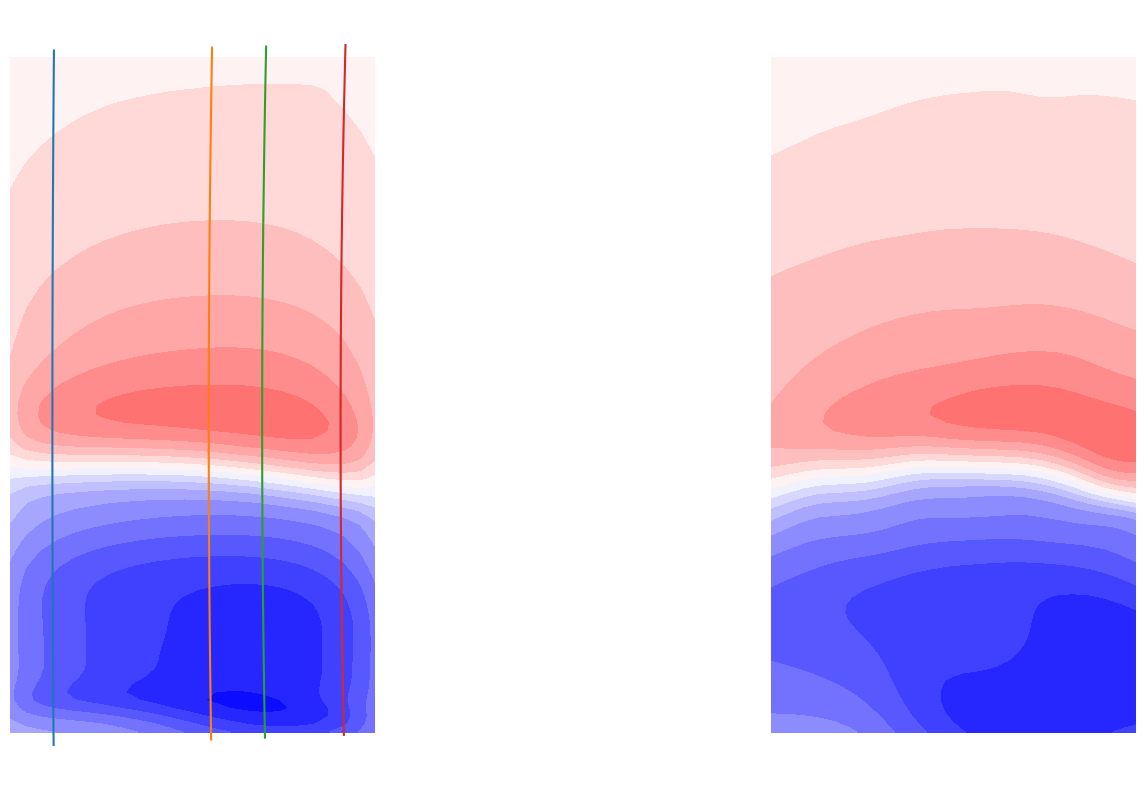

In [15]:

# PLOT ON MAP NEXT TO MHD OUTPUT
Ge_map, Gn_map, Gu_map = get_SECS_B_G_matrices(grid.lat_mesh.flatten(), grid.lon_mesh.flatten(), (6371.2 + H_b) * 1e3, grid.lat.flatten(), grid.lon.flatten(), RI = RI )

Br_map = Gu_map.dot(m).reshape(grid.lat_mesh.shape)


fig, axes = plt.subplots(figsize = (18, 10), ncols = 2, sharey = True)

axINV = axes[0]

axINV.contourf(grid.xi_mesh, grid.eta_mesh, Br_map, cmap = plt.cm.bwr, levels = np.linspace(-500, 500, 21))
axINV.set_aspect('equal')

# plot measurement tracks:
for i in range(4):
    _xi, _eta = projection.geo2cube(lon_obs[i], lat_obs[i])
    axINV.plot(_xi, _eta, color = 'C' + str(i), zorder = 3)



axMHD = axes[1]
Br_mhd_map = get_MHD_dB(grid.lat_mesh, grid.lon_mesh, component = 'Br [nT]', fn = mhd_dB_fn)
axMHD.contourf(grid.xi_mesh, grid.eta_mesh, Br_mhd_map, cmap = plt.cm.bwr, levels = np.linspace(-500, 500, 21))
axMHD.set_aspect('equal')

for ax in axes:
    ax.set_axis_off()


## Step 6: Add Gaussian noise with different sigmas and repeat inverison

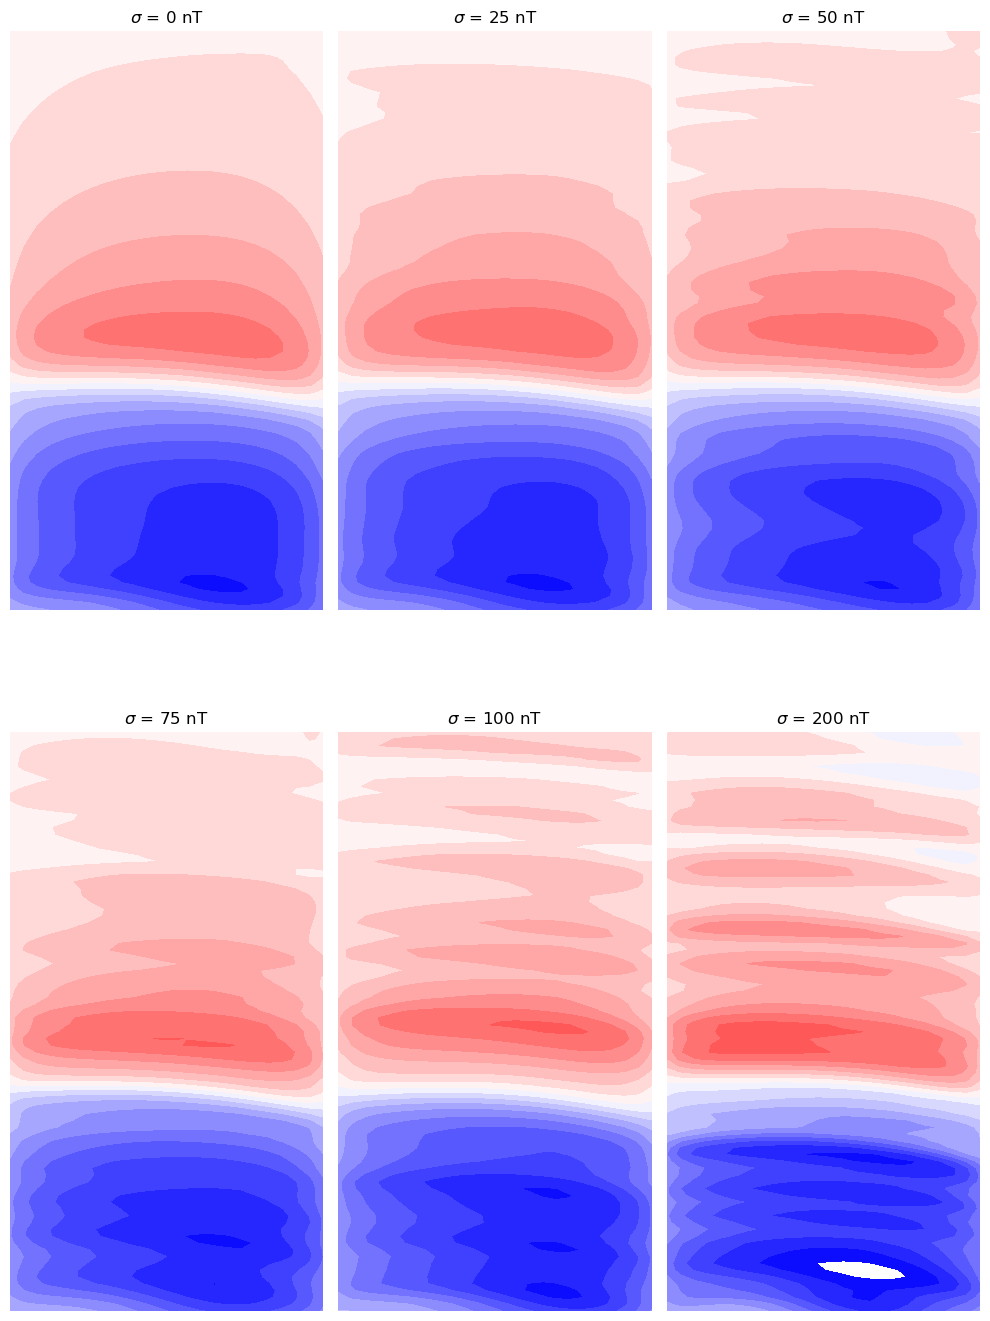

In [16]:
noise_levels = [0, 25, 50, 75, 100, 200, 400]
data_vectors = [Br_mhd.flatten() + np.random.normal(size = Br_mhd.size, scale = level) for level in noise_levels]
solution_vectors = [np.ravel(SS.dot(Gu.T.dot(d))) for d in data_vectors]

# plot maps of Br:
fig, axes = plt.subplots(figsize = (10, 15), nrows = 2, ncols = 3)

for ax, m, noise in zip(axes.flatten(), solution_vectors, noise_levels):
    Br_map = Gu_map.dot(m)
    ax.contourf(grid.xi_mesh, grid.eta_mesh, Br_map.reshape(grid.eta_mesh.shape), cmap = plt.cm.bwr, levels = np.linspace(-500, 500, 21))
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title(r'$\sigma$ = ' + str(noise) + ' nT')

plt.tight_layout()